# Noise PSDs by USRP Power
## Import the libraries

In [1]:
import sys, os, glob, h5py
import time, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import TimestreamHelperFunctions as Thf
import ResonanceFitter as resfit

## Load some parameters

In [2]:
## MB Results come from fitting a temperature scan at a specified RF power
use_nexus_MBvals = False

if use_nexus_MBvals:
    ## As measured in NEXUS
    MB_fit_vals = np.array([4.24216+9.75e-6, 
                            0.177  ,
                            0.0125 ,
                            4.1e7  ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
else:
    ## As measured on Caltech sister device (https://arxiv.org/pdf/2111.08064.pdf)
    MB_fit_vals = np.array([4.24201000, 
                            0.184     ,
                            0.03801   ,
                            4.05538e5 ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
    
## How much attenuation is in the lines before the chip
# line_atten_dB_NEXUS = 56.5
line_atten_dB_NEXUS = 60

## Define the noise runs in power order

In [3]:
## 10/17 Al Runs - Shield Open, No Laser, No sources (NR 22)
series_list = np.array([
    "20231017_134902",
    "20231017_135104",
    "20231017_135259",
    "20231017_135454",
    "20231017_135649",
    "20231017_135844",
    "20231017_140039",
    "20231017_140234",
    "20231017_141117",
    "20231017_142524",
    "20231017_142937",
    "20231017_143138"
])

P_min = -70 ; P_max = -15 ; P_step = 5
powers_list = np.arange(start=P_min, stop=P_max+P_step, step=P_step)

In [4]:
# ## 10/9 Al Runs - Shield Open, No Laser, No sources (NR 22)
# series_list = np.array([
#     "20231009_091735", 
#     "20231009_091545", 
#     "20231009_091355", 
#     "20231009_091205", 
#     "20231009_091015", 
#     "20231009_090825", 
#     "20231009_090635", 
#     "20231009_090445", 
#     "20231009_090255", 
#     "20231009_090106", 
#     "20231009_085917", 
#     "20231009_085722", 
# ])

# P_min = -70 ; P_max = -15 ; P_step = 5
# powers_list = np.arange(start=P_max, stop=P_min-P_step, step=-P_step)

In [5]:
# ## 11/8 Al Runs - Shield Closed, No Laser, No sources (NR 15)
# series_list = np.array([
#     "20221108_093729",
#     "20221108_093600",
#     "20221108_093431",
#     "20221108_093301",
#     "20221108_093132",
#     "20221108_093003",
#     "20221108_092834",
#     "20221108_092702",
#     "20221108_092534",
#     "20221108_092406",
#     "20221108_092238",
#     "20221108_092104",
# ])

# P_min = -70 ; P_max = -15 ; P_step = 5
# powers_list = np.arange(start=P_max, stop=P_min-P_step, step=-P_step)

In [6]:
# ## 2/12/23 Al Runs - Shield Closed, No Laser, No sources (NR 17)
# series_list = np.array([
#     "20230212_224409",
#     "20230212_224240",
#     "20230212_224111",
#     "20230212_223942",
#     "20230212_223813",
#     "20230212_223644",
#     "20230212_223515",
#     "20230212_223346",
#     "20230212_223217",
#     "20230212_223049",
#     "20230212_222921",
#     "20230212_222746",
# ])

# P_min = -70 ; P_max = -15 ; P_step = 5
# powers_list = np.arange(start=P_max, stop=P_min-P_step, step=-P_step)

In [7]:
# ## 2/22/23 Nb7 Runs - Shield Closed, No Laser, No sources (NR 17)
# series_list = np.array([
#     "20230222_155910", 
#     "20230222_155740", 
#     "20230222_155610", 
#     "20230222_155440", 
#     "20230222_155310", 
#     "20230222_155140", 
#     "20230222_155010", 
#     "20230222_154840", 
#     "20230222_154711", 
#     "20230222_154542", 
#     "20230222_154413", 
#     "20230222_154237"
# ])

# P_min = -70 ; P_max = -15 ; P_step = 5
# powers_list = np.arange(start=P_max, stop=P_min-P_step, step=-P_step)

# series_list = series_list[::-1]
# powers_list = powers_list[::-1]

In [8]:
pwr_on_chip = Prf.power_on_feedline(powers_list,line_atten_dB_NEXUS)

for i in np.arange(len(series_list)):
    print(series_list[i], ":", powers_list[i],"/",pwr_on_chip[i], "dBm")

20231017_134902 : -70 / -130 dBm
20231017_135104 : -65 / -125 dBm
20231017_135259 : -60 / -120 dBm
20231017_135454 : -55 / -115 dBm
20231017_135649 : -50 / -110 dBm
20231017_135844 : -45 / -105 dBm
20231017_140039 : -40 / -100 dBm
20231017_140234 : -35 / -95 dBm
20231017_141117 : -30 / -90 dBm
20231017_142524 : -25 / -85 dBm
20231017_142937 : -20 / -80 dBm
20231017_143138 : -15 / -75 dBm


## Check one VNA File

In [9]:
sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series_list[11], verbose=True)
metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)
print(avg_frqs, avg_S21s)

Line Delay file:  None
VNA scan file:    USRP_VNA_20231017_143138.h5
Noise ts files:   ['USRP_Noise_20231017_143138_delta0.h5']
Laser ts files:   []
Summary file:	 noise_averages_20231017_143138.h5
[5387.401279 5387.405209 5387.40914 ] [0.02660727-0.01718786j 0.02638292-0.01723766j 0.02651774-0.01696416j]


<IPython.core.display.Javascript object>


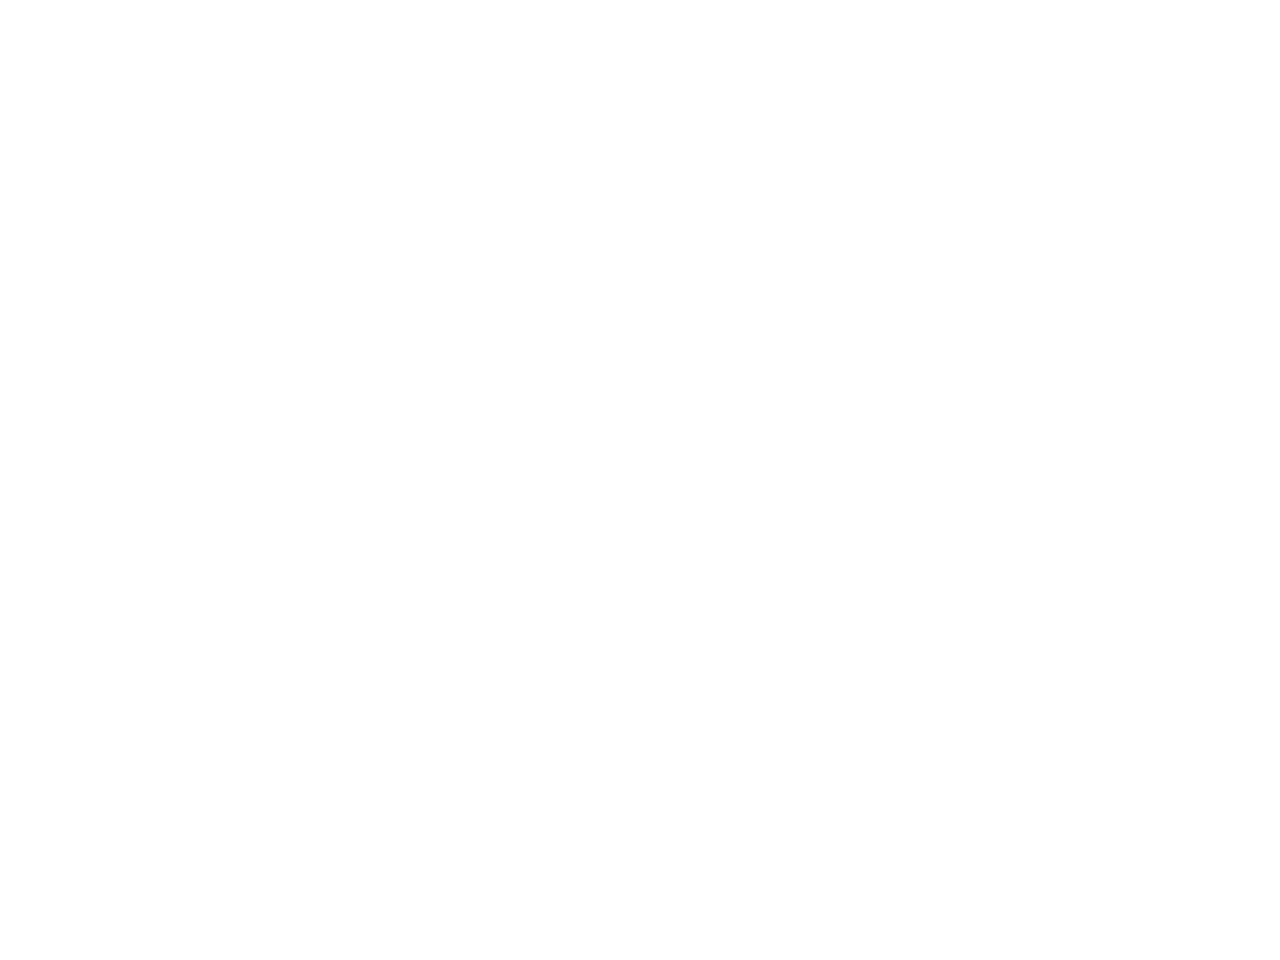

<IPython.core.display.Javascript object>


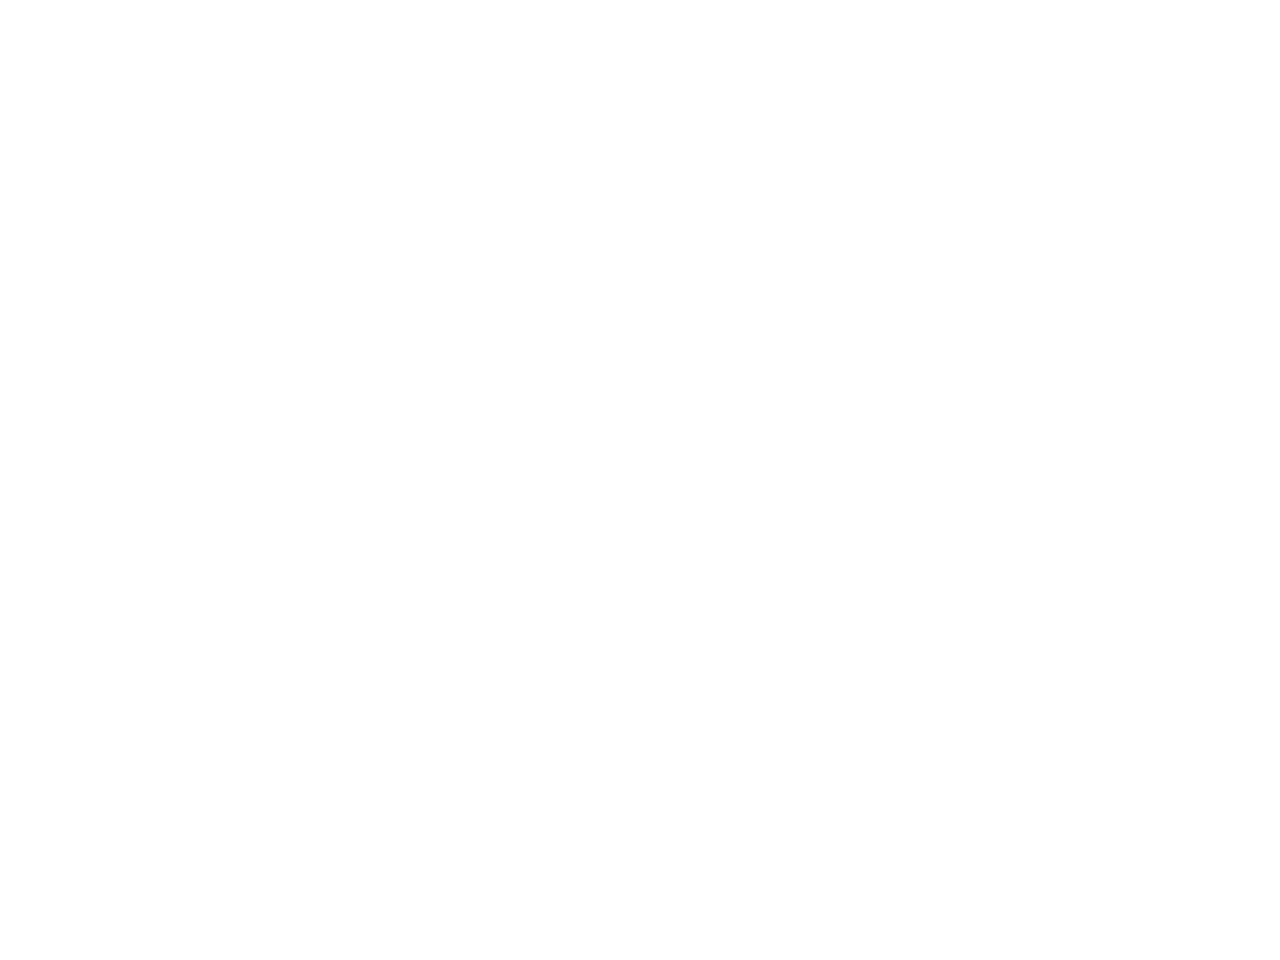

<IPython.core.display.Javascript object>


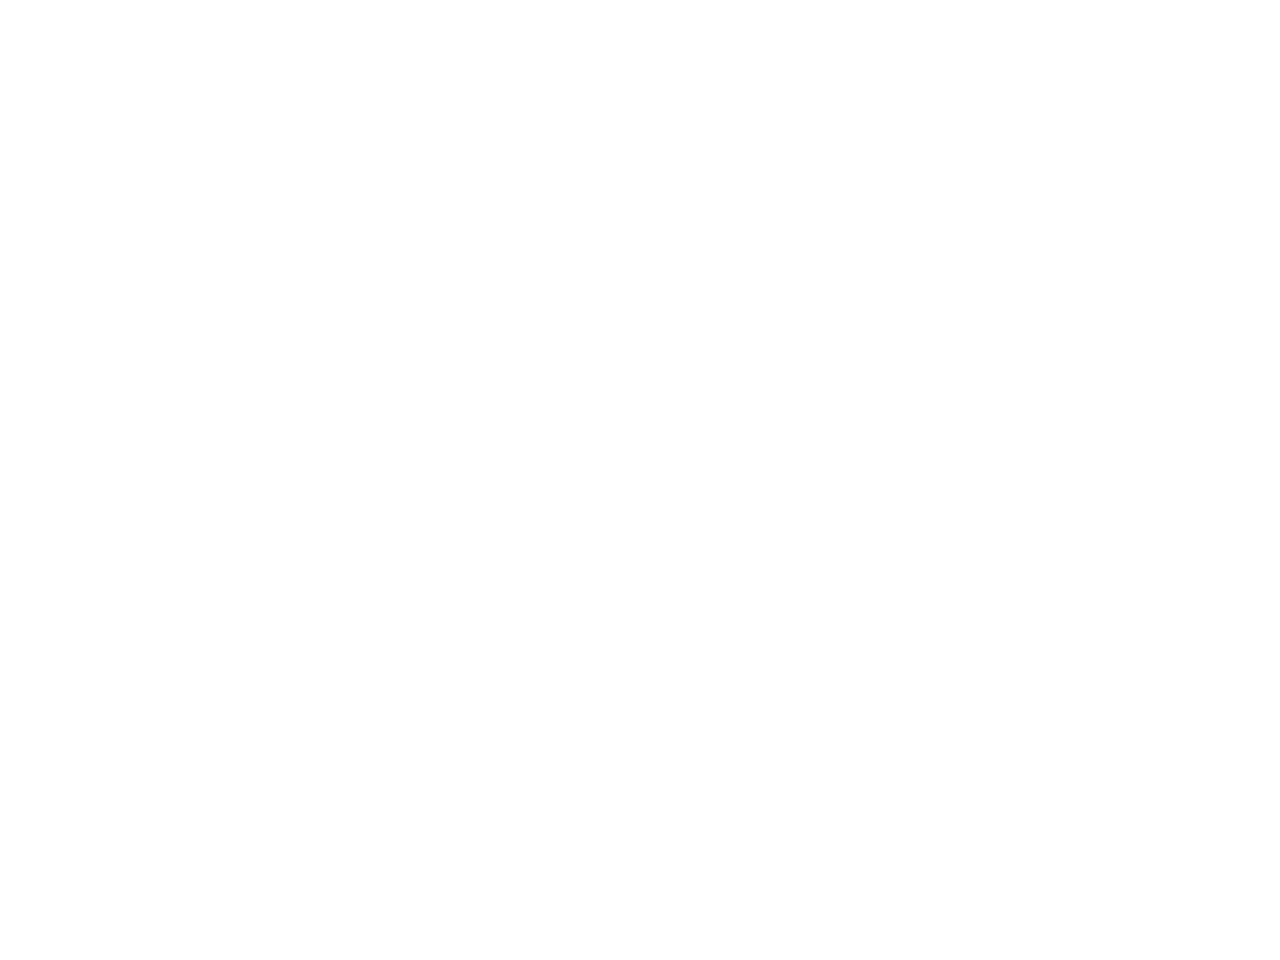

<IPython.core.display.Javascript object>


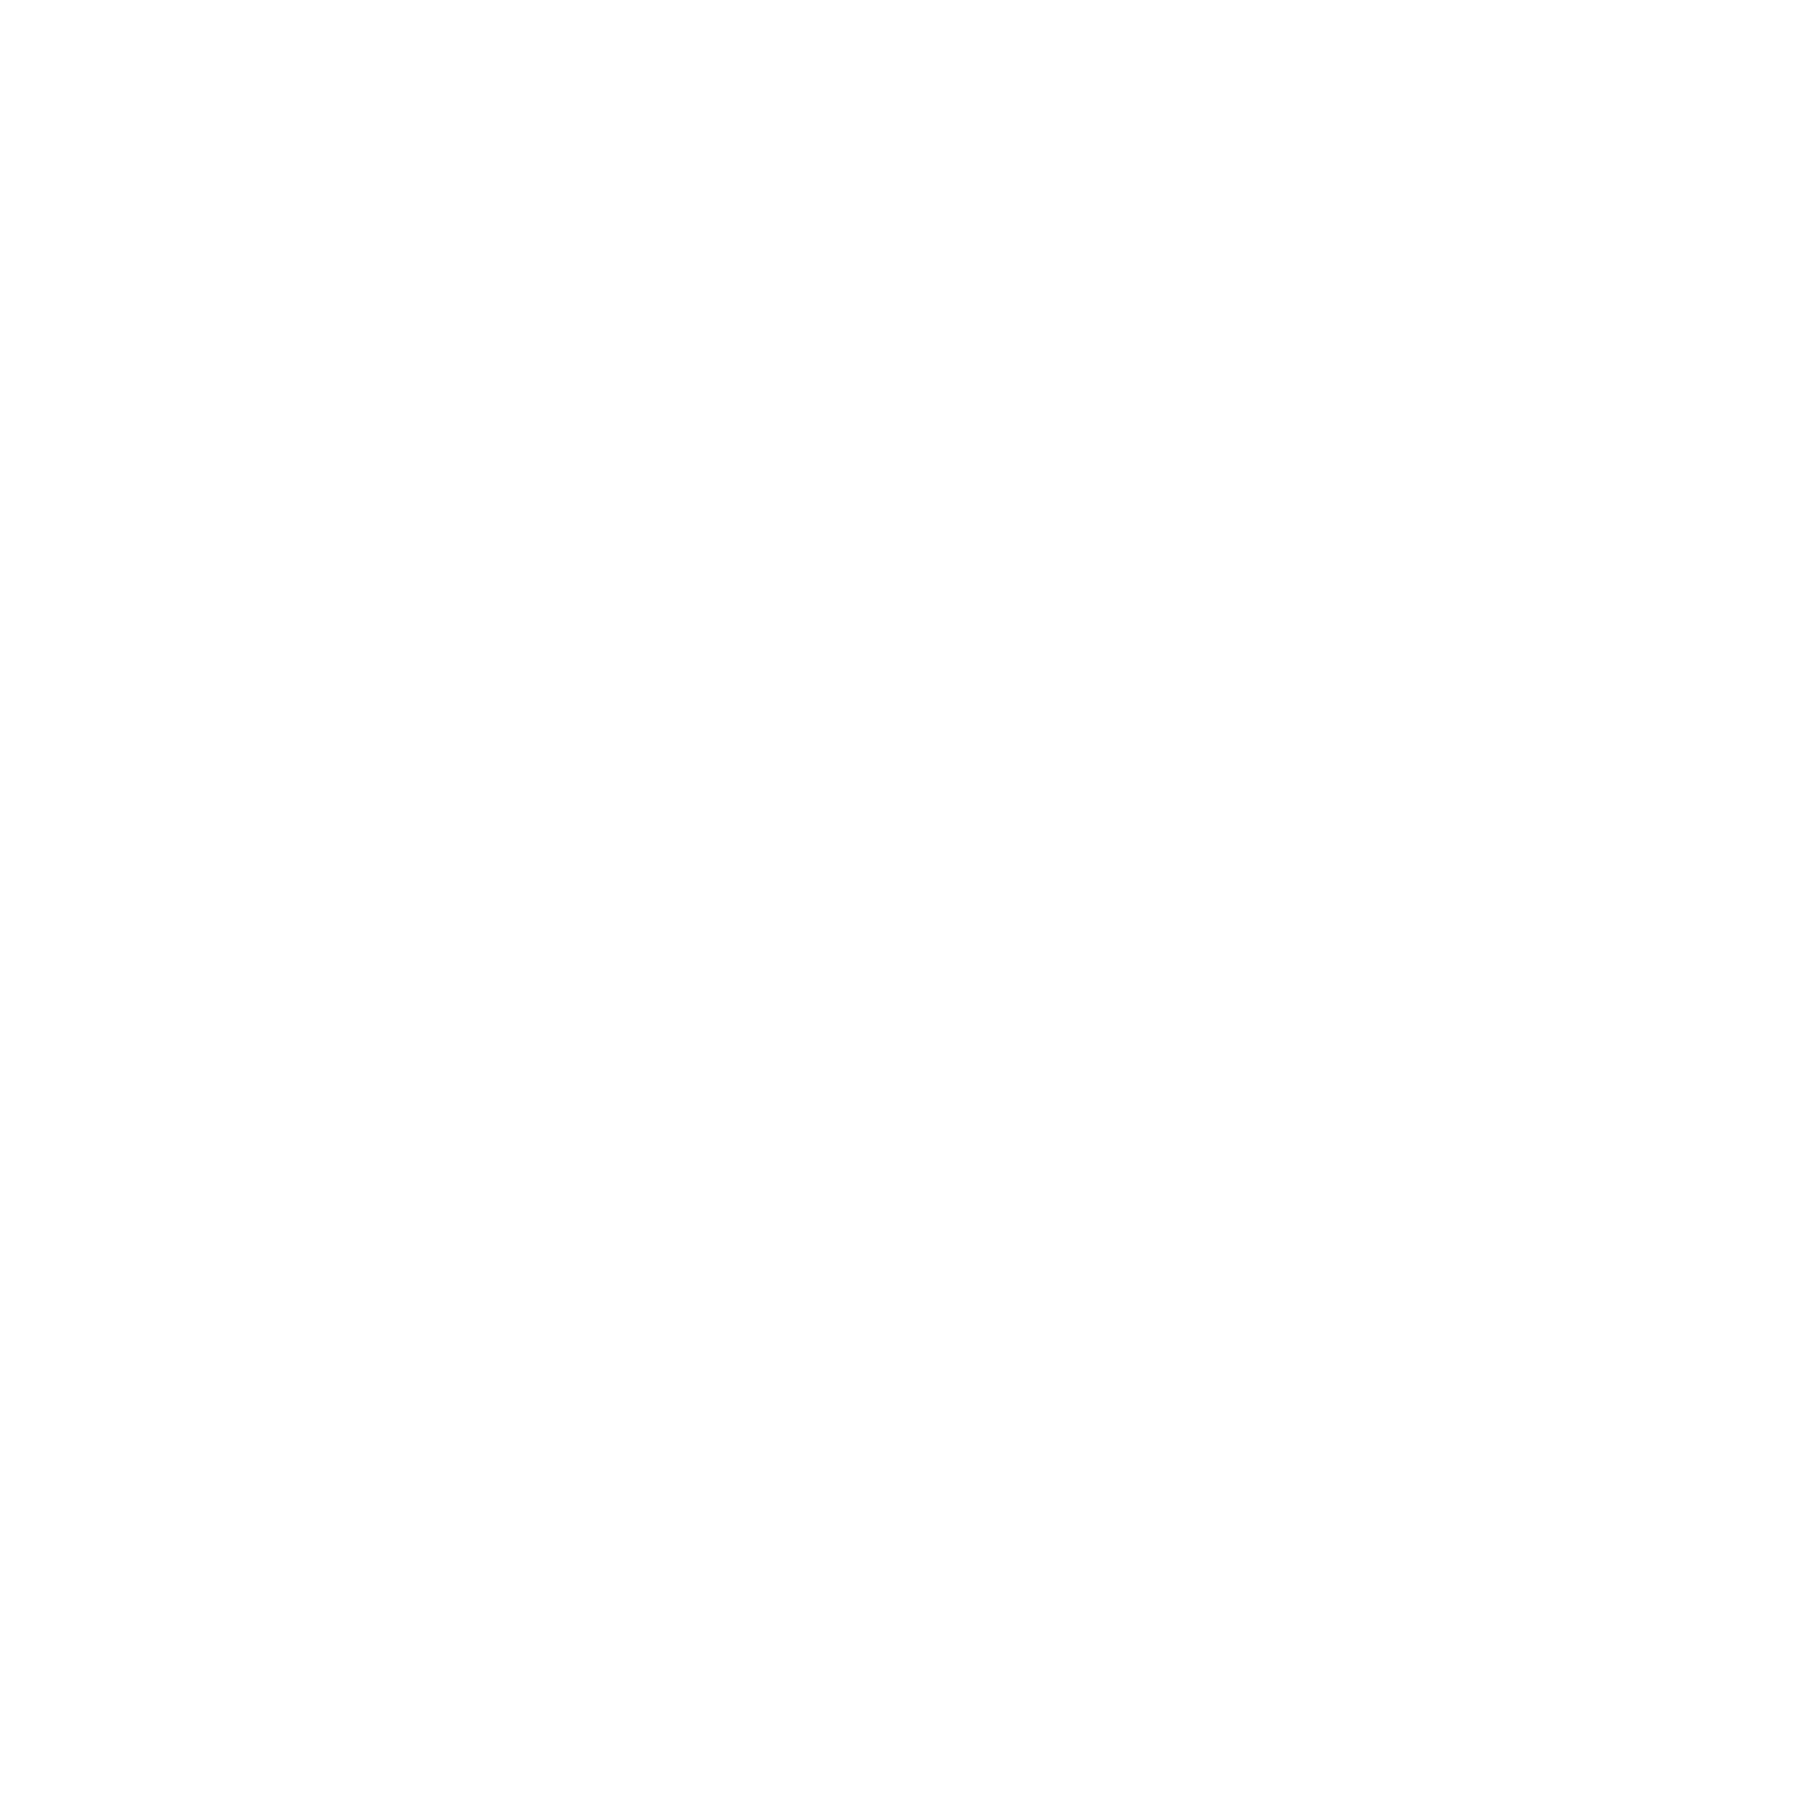

<IPython.core.display.Javascript object>


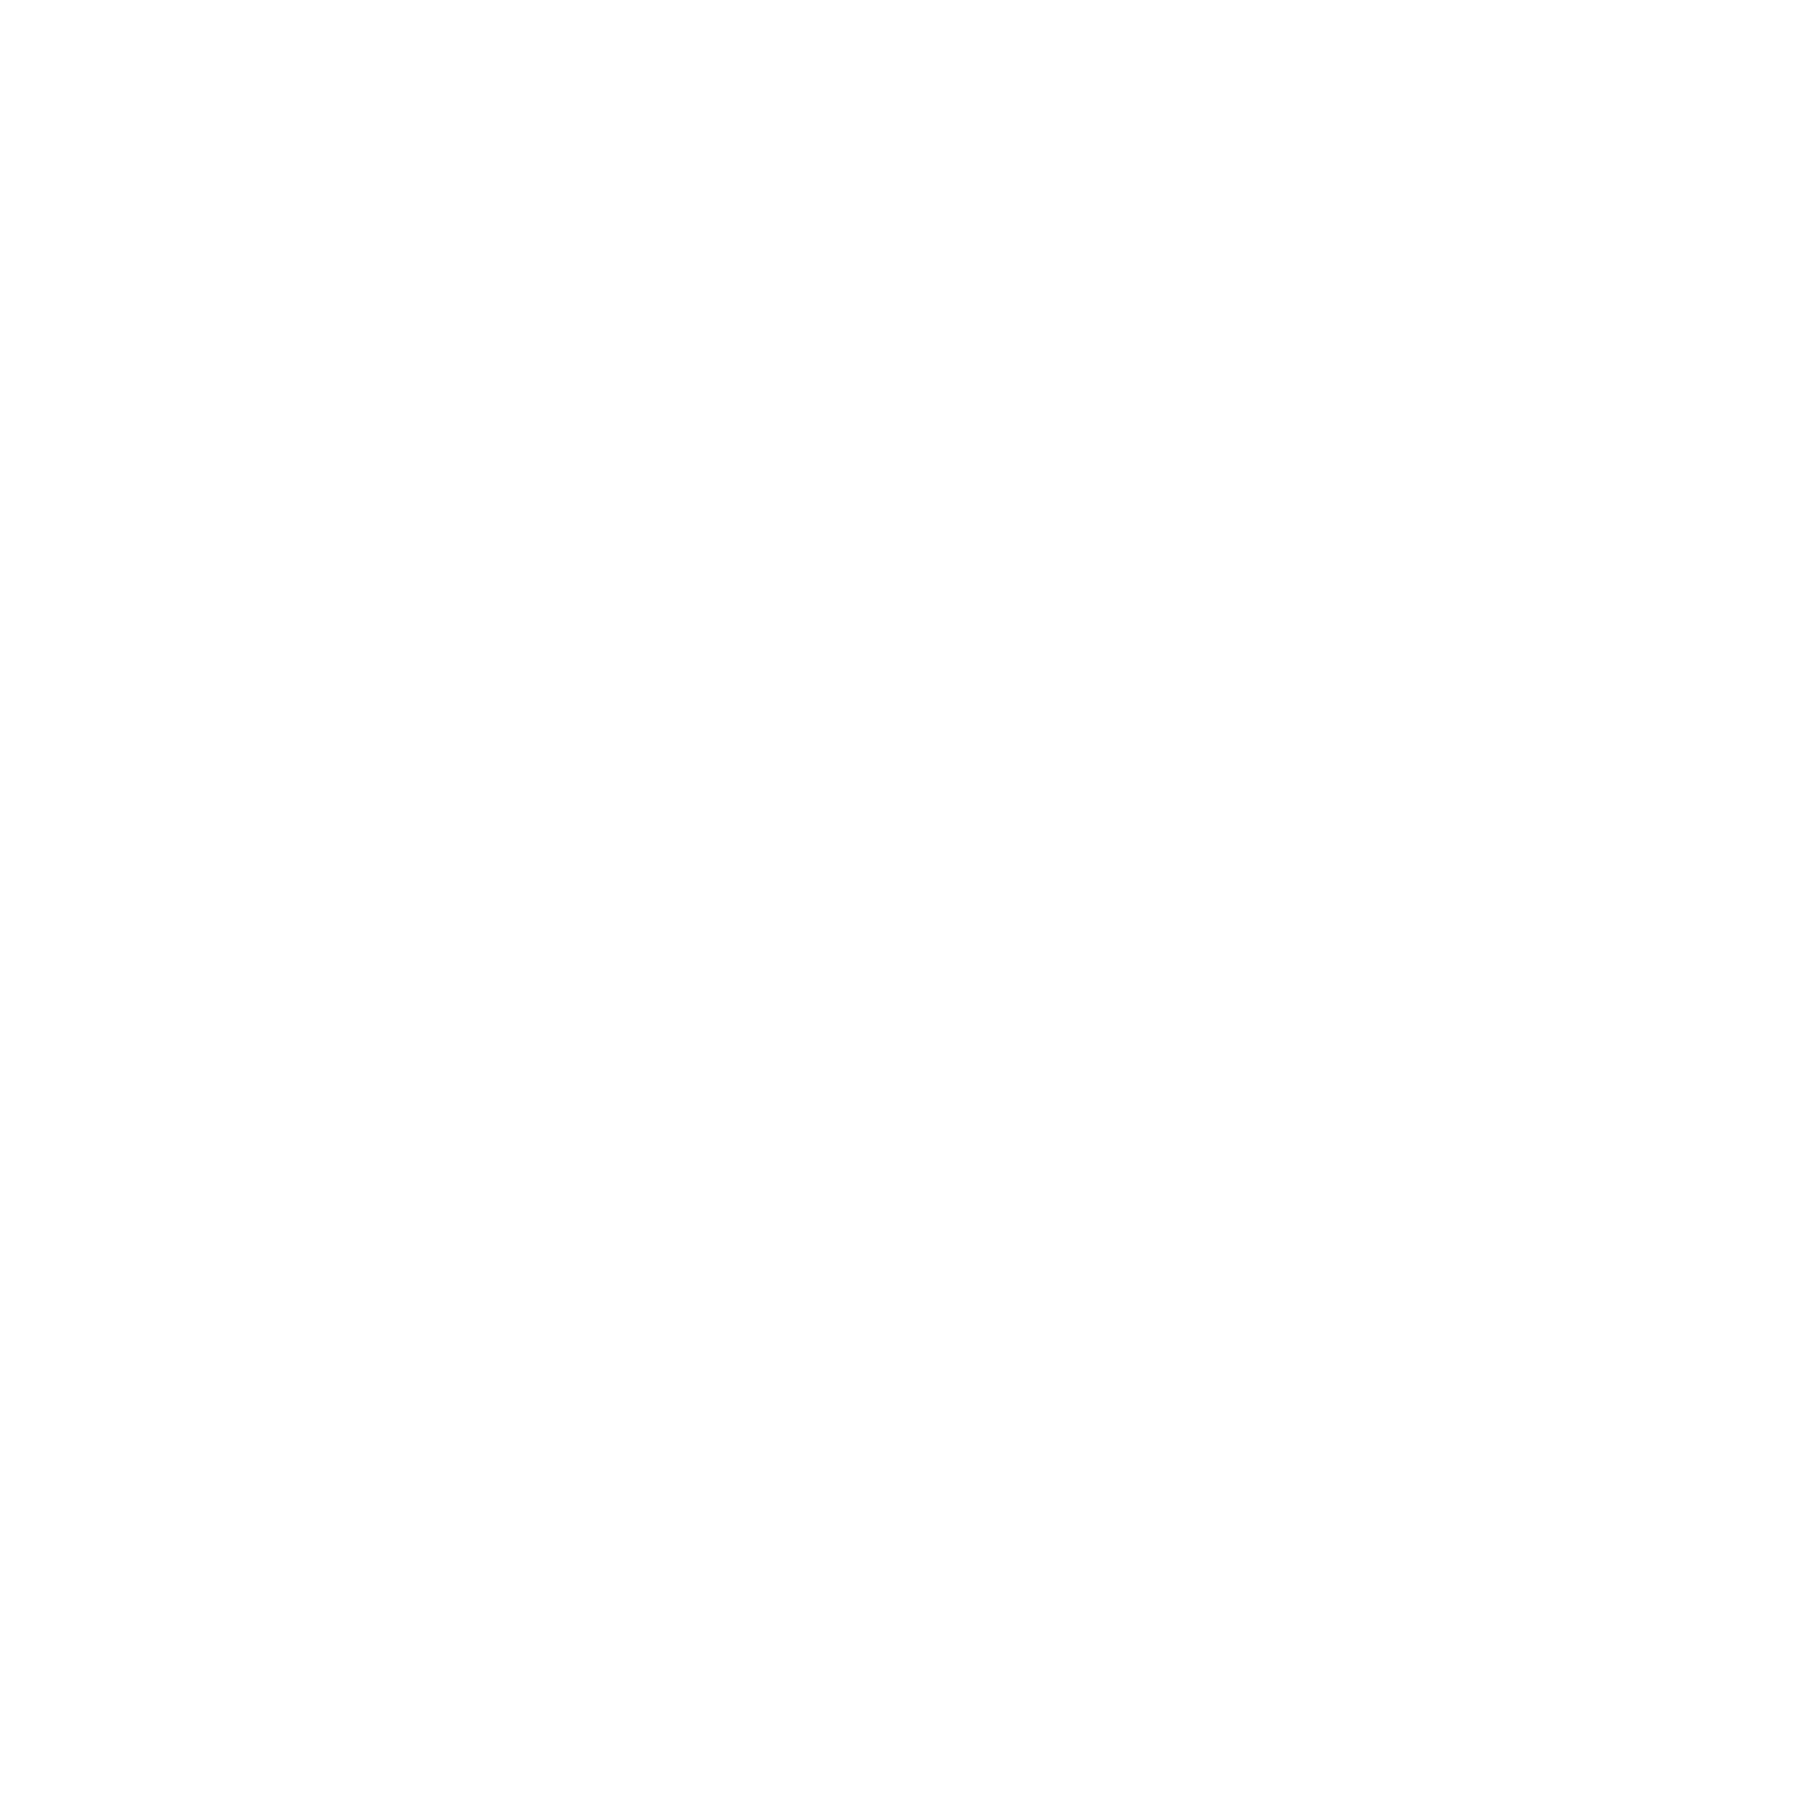

In [10]:
%matplotlib notebook
PUf.plot_VNA(vna_file,[avg_frqs[1]*1e-3])

### Get an array of Qc and Qr values

In [11]:
Qrs = np.zeros(len(series_list))
Qcs = np.zeros(len(series_list))
frs = np.zeros(len(series_list))
f0s = np.zeros(len(series_list))

for i, series in enumerate(series_list):
    sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series, verbose=True)
    metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)
    
    res_pars, res_errs = resfit.finefit(*PUf.read_vna(vna_file), [avg_frqs[1]], 
                                    restrict_fit_MHz=None, plot=False, verbose=False)
    
    Qrs[i] = res_pars["Qr"]
    Qcs[i] = res_pars["Qc"]
    frs[i] = res_pars["f0"]
    f0s[i] = avg_frqs[1]

    
# for i in np.arange(len(Qrs)):
#     print(f0s[i], frs[i], Qrs[i], Qcs[i])
    
for i, series in enumerate(series_list):
    print(series, 1e6*(f0s[i]-frs[i]),"Hz")

Line Delay file:  USRP_Delay_20231017_134902.h5
VNA scan file:    USRP_VNA_20231017_134902.h5
Noise ts files:   ['USRP_Noise_20231017_134902_delta0.h5']
Laser ts files:   []
Summary file:	 noise_averages_20231017_134902.h5
Line Delay file:  None
VNA scan file:    USRP_VNA_20231017_135104.h5
Noise ts files:   ['USRP_Noise_20231017_135104_delta0.h5']
Laser ts files:   []
Summary file:	 noise_averages_20231017_135104.h5
Line Delay file:  None
VNA scan file:    USRP_VNA_20231017_135259.h5
Noise ts files:   ['USRP_Noise_20231017_135259_delta0.h5']
Laser ts files:   []
Summary file:	 noise_averages_20231017_135259.h5
Line Delay file:  None
VNA scan file:    USRP_VNA_20231017_135454.h5
Noise ts files:   ['USRP_Noise_20231017_135454_delta0.h5']
Laser ts files:   []
Summary file:	 noise_averages_20231017_135454.h5
Line Delay file:  None
VNA scan file:    USRP_VNA_20231017_135649.h5
Noise ts files:   ['USRP_Noise_20231017_135649_delta0.h5']
Laser ts files:   []
Summary file:	 noise_averages_2023

### Determine power stored in resonator

In [12]:
pwr_in_res  = Prf.power_in_resonator(pwr_on_chip, f0s, Qrs, Qcs, frs)
for i in np.arange(len(series_list)):
    print(series_list[i], ":", powers_list[i],"/",pwr_on_chip[i],"/",pwr_in_res[i], "dBm")

20231017_134902 : -70 / -130 / -93.82330806489449 dBm
20231017_135104 : -65 / -125 / -87.48206786743735 dBm
20231017_135259 : -60 / -120 / -82.84360663861395 dBm
20231017_135454 : -55 / -115 / -77.729586035676 dBm
20231017_135649 : -50 / -110 / -72.36853547694535 dBm
20231017_135844 : -45 / -105 / -67.75737217859815 dBm
20231017_140039 : -40 / -100 / -62.28854864935912 dBm
20231017_140234 : -35 / -95 / -56.99006468883452 dBm
20231017_141117 : -30 / -90 / -51.86654051587503 dBm
20231017_142524 : -25 / -85 / -46.946624994251145 dBm
20231017_142937 : -20 / -80 / -41.60523848073375 dBm
20231017_143138 : -15 / -75 / -36.63711938662826 dBm


## Calculate and plot PSDs for every power

In [13]:
%matplotlib notebook
# plt.rcParams.update({'font.size': 18})

In [14]:
f_interst = [1.0e3]

In [15]:
psd_interst = Thf.PlotPSDsByPower(series_list, pwr_in_res, #pwr_on_chip, 
    fHz_range     = [1e2,3e5],
    e_b_PSDrange  = [5e-14,4e-11],
    r_b_PSDrange  = [1e-18,1e-10], # [5e-24,1e-15], #
#     q_b_PSDrange  = [2e-5,2e-1],
#     q_b_PSDrange  = [7e-6,1e1],
    MB_fit_result = None, # MB_fit_vals, # 
    PSD_lo_f      = 1e2, 
    PSD_hi_f      = 5e4, 
    f_transient   = 0.05,
    f_data        = f_interst,
    verbose       = False,
    psd_to_file   = True,
    res_to_file   = True,
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20231017/20231017_134902/USRP_Noise_20231017_134902_delta0.h5 because override=True!
found 39 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20231017/20231017_134902/USRP_Noise_20231017_134902_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20231017/20231017_135104/USRP_Noise_20231017_135104_delta0.h5 because override=True!
found 43 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20231017/20231017_135104/USRP_Noise_20231017_135104_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Sca

In [16]:
def tls_shape(f,S_fmin,fmin):
    fdep = 1./np.sqrt(f)
    A    = S_fmin * np.sqrt(fmin)
    return A*fdep

## Draw some TLS lines to guide the eye
ax0 = plt.figure(4).gca()

ylim = ax0.get_ylim()

A_vals    = np.logspace(start=-22,stop=-15,num=8)
fHz_range = np.linspace(start=1e2,stop=3e5,num=100)
for A in A_vals:
    ax0.plot(fHz_range,tls_shape(fHz_range,A,fHz_range[0]),'k:',alpha=0.5)

ax0.set_ylim(ylim)

# ## Adjust the y-axis limits
# ax0 = plt.figure(4).gca()
# ax0.set_ylim([1e-21,ylim[1]])

# ax0 = plt.figure(3).gca()
# ax0.set_ylim([1e-21,ylim[1]])

(1e-18, 1e-10)

In [17]:
print(psd_interst)

{-93.82330806489449: array([[1.00000000e+03, 6.63301788e-14, 3.38328803e-13, 4.41100487e-12,
        1.11992508e-12]]), -87.48206786743735: array([[1.00000000e+03, 8.70617803e-14, 2.39875008e-13, 1.29329892e-12,
        3.17658675e-13]]), -82.84360663861395: array([[1.00000000e+03, 1.08102482e-13, 1.50372645e-13, 4.18061815e-13,
        1.03484849e-13]]), -77.729586035676: array([[1.00000000e+03, 1.13784155e-13, 1.23431028e-13, 1.33595378e-13,
        3.26646676e-14]]), -72.36853547694535: array([[1.00000000e+03, 1.10635381e-13, 1.21109661e-13, 3.54827986e-14,
        8.82613853e-15]]), -67.75737217859815: array([[1.00000000e+03, 1.15916194e-13, 1.16914998e-13, 1.01855323e-14,
        2.55987585e-15]]), -62.28854864935912: array([[1.00000000e+03, 1.10855620e-13, 1.17718184e-13, 2.96979262e-15,
        7.16684094e-16]]), -56.99006468883452: array([[1.00000000e+03, 1.17861971e-13, 1.23192717e-13, 1.00686378e-15,
        2.39610886e-16]]), -51.86654051587503: array([[1.00000000e+03, 1.127

## Read in the Caltech PSD data

In [18]:
# path  = "/data/Misc"
# f_pfx = "LTD19 "
# f_sfx = " noise qp.csv"

# k1_data = np.loadtxt(os.path.join(path,f_pfx+"k1"+f_sfx), delimiter=",", skiprows=1)
# k2_data = np.loadtxt(os.path.join(path,f_pfx+"k2"+f_sfx), delimiter=",", skiprows=1)

# caltech_powers = np.array([-80])
# caltech_powers = np.arange(start=-110, stop=-75, step=5)
# print(caltech_powers)

In [19]:
path  = "/data/Misc"
f_pfx = "LTD19 "
f_sfx = " noise qp.csv"

k1_data = pd.read_csv(os.path.join(path,f_pfx+"k1"+f_sfx), sep=",", header=0, index_col=False)
k2_data = pd.read_csv(os.path.join(path,f_pfx+"k2"+f_sfx), sep=",", header=0, index_col=False)

line_atten_dB_caltech = 70

In [20]:
caltech_powers = np.array(k1_data.keys())[1:].astype(int)
caltech_powers = caltech_powers - line_atten_dB_caltech
print(caltech_powers)

[-110 -105 -100  -95  -90  -85  -80]


<IPython.core.display.Javascript object>


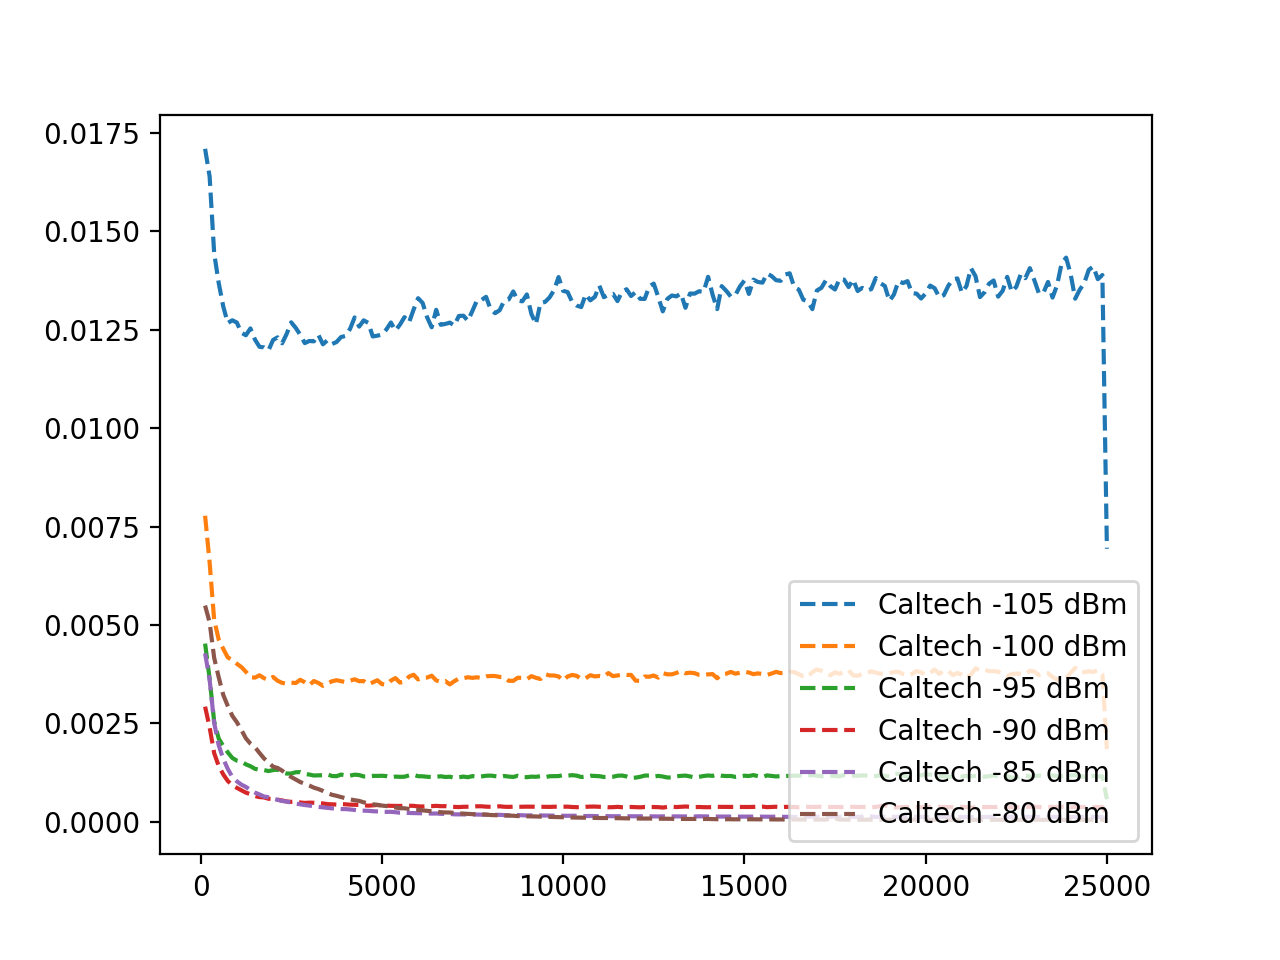

<IPython.core.display.Javascript object>


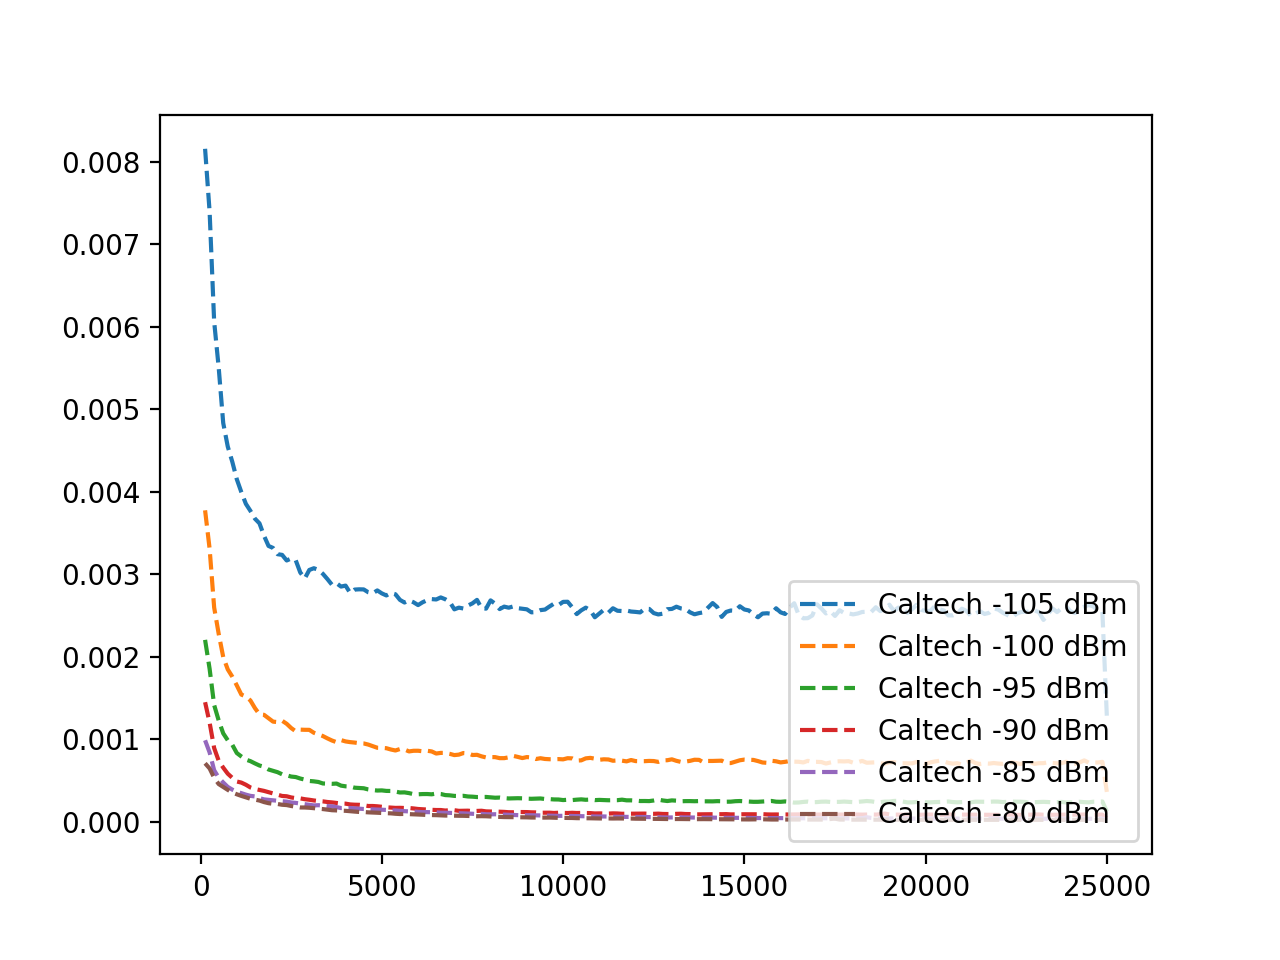

In [21]:
## Count how many columns of PSDs there are
n_psd_cols = len(caltech_powers)

## Loop over every PSD (by power)
# for i in np.arange(n_psd_cols)+1:
for i in np.arange(n_psd_cols-1)+2:
    ## Pull the right column
    this_k1_data = k1_data[k1_data.keys()[i]]
    this_k2_data = k2_data[k2_data.keys()[i]]
    
    ## Pick the color
#     c = "C" + str(i-1)
    c = "C" + str(i-2)
    
    ## Add the k1 data to the right plot
    ax1 = plt.figure(5).gca()
    ax1.plot(k1_data['freq'],this_k1_data,color=c,ls='--',label="Caltech "+str(caltech_powers[i-1])+" dBm")
    
    ## Add the k2 data to the right plot
    ax2 = plt.figure(6).gca()
    ax2.plot(k2_data['freq'],this_k2_data,color=c,ls='--',label="Caltech "+str(caltech_powers[i-1])+" dBm")
    
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')

## Check the readout frequencies for each power

In [22]:
for i in np.arange(len(series_list)):
    sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series_list[i], verbose=False)
    metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)
    print(series_list[i],"(",pwr_on_chip[i],"dBm) f_r:", avg_frqs[0], "MHz")

20231017_134902 ( -130 dBm) f_r: 5387.387823 MHz
20231017_135104 ( -125 dBm) f_r: 5387.400676 MHz
20231017_135259 ( -120 dBm) f_r: 5387.395361 MHz
20231017_135454 ( -115 dBm) f_r: 5387.398533 MHz
20231017_135649 ( -110 dBm) f_r: 5387.398744 MHz
20231017_135844 ( -105 dBm) f_r: 5387.394178 MHz
20231017_140039 ( -100 dBm) f_r: 5387.395512 MHz
20231017_140234 ( -95 dBm) f_r: 5387.398445 MHz
20231017_141117 ( -90 dBm) f_r: 5387.399974 MHz
20231017_142524 ( -85 dBm) f_r: 5387.39869 MHz
20231017_142937 ( -80 dBm) f_r: 5387.400006 MHz
20231017_143138 ( -75 dBm) f_r: 5387.401279 MHz


## Investigate TLS contribution

In [23]:
def dBm_to_mW(dBm):
    return 1.0 * np.power(10,dBm/10)

In [24]:
df_f_PSD_pts = np.zeros(len(pwr_on_chip))

for i in np.arange(len(pwr_on_chip)):
    d = psd_interst[pwr_on_chip[i]][0]
    df_f_PSD_pts[i] = d[4]
    print(pwr_on_chip[i],d[0],d[4],dBm_to_mW(pwr_on_chip[i]))

KeyError: -130

In [ ]:
fig = plt.figure()
ax1 = fig.gca()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(r"$S_\mathrm{TLS}(\nu=1$ kHz) $\left[ \frac{(df/f)^2}{\mathrm{Hz}} \right]$")
ax1.set_xlabel("Power on chip [mW]")

for i in np.arange(len(pwr_on_chip)):
    ax1.scatter(dBm_to_mW(pwr_on_chip[i]),df_f_PSD_pts[i],marker='s',color='C'+str(i))

In [ ]:
from scipy.optimize import curve_fit

def pow_law(x,A,n):
    return A * np.power(x,n)

line = lambda lx,la,k: la + k*lx

# lx_data = np.log10(dBm_to_mW(pwr_on_chip[pwr_on_chip != -106.5]))
# ly_data = np.log10(df_f_PSD_pts[pwr_on_chip != -106.5])

lx_data = np.log10(dBm_to_mW(pwr_on_chip))[-4:]
ly_data = np.log10(df_f_PSD_pts)[-4:]

popt, pcov = curve_fit(line,lx_data,ly_data,p0=[-25,-0.5])

ax1 = plt.figure().gca()
ax1.set_xlabel(r"$\log_{10}(P_\mathrm{chip}/\mathrm{mW})$")
ax1.set_ylabel(r"$\log_{10}\left(S_\mathrm{TLS}(\nu=1 ~\mathrm{kHz}) / \left[ \frac{(df/f)^2}{\mathrm{Hz}} \right] \right)$")
ax1.scatter(lx_data,ly_data,marker='s',color='C0')

xlims = ax1.get_xlim()
xvals = np.linspace(start=xlims[0],stop=xlims[1],num=5)
yvals = line(xvals,popt[0],popt[1])
ax1.plot(xvals,yvals,'r--',label=r"fit $P^{"+str(int(100.0*popt[1])/100.0)+"}$")
ax1.legend()
ax1.set_xlim(xlims)

print("k=", popt[1])
print("a=", 10**popt[0])

In [ ]:
fig = plt.figure()
ax1 = fig.gca()
ax1.set_yscale('log')
ax1.set_ylabel(r"$S_\mathrm{TLS}(\nu=1$ kHz) $\left[ \frac{(df/f)^2}{\mathrm{Hz}} \right]$")
ax1.set_xlabel("Power on chip [dBm]")

for i in np.arange(len(pwr_on_chip)):
    ax1.scatter(pwr_on_chip[i],df_f_PSD_pts[i],marker='s',color='C'+str(i))
    
xlims = ax1.get_xlim()
xvals = np.linspace(start=xlims[0],stop=xlims[1],num=10)
yvals = pow_law(dBm_to_mW(xvals),10**popt[0],popt[1])
ax1.plot(xvals,yvals,'r--',label=r"fit $P^{"+str(int(100*popt[1])/100.)+"}$")

# ax1.plot(xvals,pow_law(dBm_to_mW(xvals),3.0e-24,-0.47),'r:',alpha=0.5,label=r"Guess $P^{-0.47}$")
# ax1.plot(xvals,pow_law(dBm_to_mW(xvals),0.8e-23,-0.43),'b:',alpha=0.5,label=r"Guess $P^{-0.43}$")
# ax1.plot(xvals,pow_law(dBm_to_mW(xvals),5.5e-25,-0.55),'g:' ,alpha=0.5,label=r"$P^{-0.55}$")

ax1.set_xlim(xlims)
ax1.legend()